# Neural Spiking Data Analysis: Transcranial Focused Ultrasound Stimulation

**Note: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Users should carefully verify all code and results before use.**

This notebook demonstrates how to access and analyze neural spiking data from rat somatosensory cortex in response to transcranial focused ultrasound stimulation (tFUS). The data was collected using a chronically implanted ultraflexible nanoelectric thread electrode.

## Dataset Overview

This dataset investigates the neural response to tFUS using:
- 128-element array transducer for stimulation
- Chronically implanted ultraflexible electrode
- Different ultrasound pressure levels (100-1300 kPa)
- Varying duty cycles (0.6-90%) at 1500 Hz PRF
- Different pulse repetition frequencies (30-4500 Hz) at 30% duty cycle
- 505 trials per recording
- 67ms stimulation duration
- 2 second inter-trial interval (with 10% jitter)

## Required Packages

This notebook requires the following Python packages:
- pynwb
- lindi
- numpy 
- matplotlib
- seaborn

# %% [markdown]
## Loading the Dataset

First, let's connect to the DANDI archive and list all available assets in this dataset:

In [1]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001363")
assets = list(dandiset.get_assets())

# Print basic information about available files
print(f"Number of NWB files: {len(assets)}")
print("\nExample files:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Number of NWB files: 55

Example files:
- sub-BH643/sub-BH643_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T182204_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T174647_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T195303_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T180423_ecephys.nwb


## Accessing an NWB File

Let's load one of the NWB files and examine its contents. We'll use a recording that tested the effect of ultrasound pressure on neural activity.

In [2]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_theme()

# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001363/assets/59d1acbb-5ad5-45f1-b211-c2e311801824/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic metadata
print("Dataset Information:")
print(f"Session Description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject Species: {nwb.subject.species}")
print(f"Subject Age: {nwb.subject.age}")
print(f"Institution: {nwb.institution}")

Dataset Information:
Session Description: Rat Ultrasound Array Stimulation
Subject ID: BH589
Subject Species: Rattus norvegicus
Subject Age: P24W
Institution: Carnegie Mellon University


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Exploring the Recording Setup

The dataset uses a flexible electrode array for recording neural activity. Let's visualize the electrode configuration:

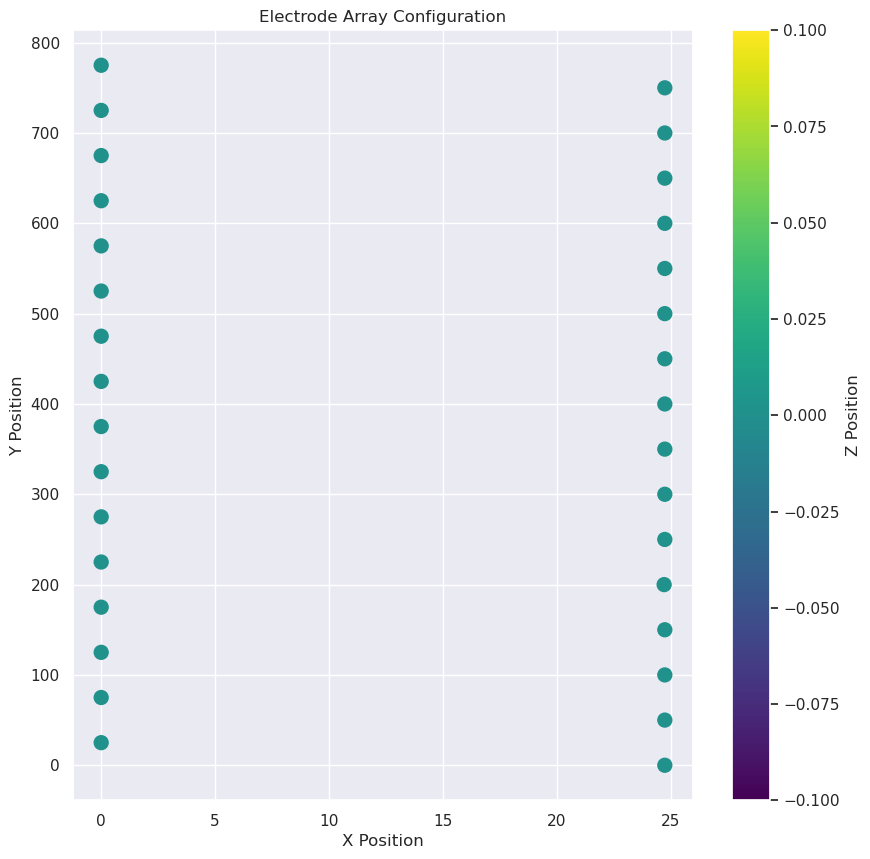


Electrode Information:
Number of electrodes: 32
Available electrode metadata: ('x', 'y', 'z', 'imp', 'location', 'filtering', 'group', 'group_name')


In [3]:
# Get electrode information
electrodes = nwb.electrodes
x_pos = electrodes['x'].data[:]
y_pos = electrodes['y'].data[:]
z_pos = electrodes['z'].data[:]

# Plot electrode positions
plt.figure(figsize=(10, 10))
plt.scatter(x_pos, y_pos, c=z_pos, cmap='viridis', s=100)
plt.colorbar(label='Z Position')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Electrode Array Configuration')
plt.grid(True)
plt.show()

# Print electrode details
print("\nElectrode Information:")
print(f"Number of electrodes: {len(x_pos)}")
print("Available electrode metadata:", electrodes.colnames)

## Analyzing Neural Responses

The dataset contains neural recordings during transcranial focused ultrasound stimulation. Each recording has multiple trials where ultrasound was applied for 67ms. Let's examine:
1. Trial timing information
2. Example neural responses from individual trials
3. Trial-averaged responses

In [4]:
# Get trial information
trials = nwb.intervals['trials']
trial_starts = trials['start_time'][:]
trial_stops = trials['stop_time'][:]

print("Trial Information:")
print(f"Number of trials: {len(trial_starts)}")
print(f"Average trial duration: {np.mean(trial_stops - trial_starts):.3f} seconds")
print(f"Mean inter-trial interval: {np.mean(trial_starts[1:] - trial_starts[:-1]):.3f} seconds")

Trial Information:
Number of trials: 500
Average trial duration: 1.500 seconds
Mean inter-trial interval: 2.501 seconds


### Visualizing Neural Activity

Let's look at neural activity around the ultrasound stimulation. We'll examine both individual trial examples and trial-averaged responses:

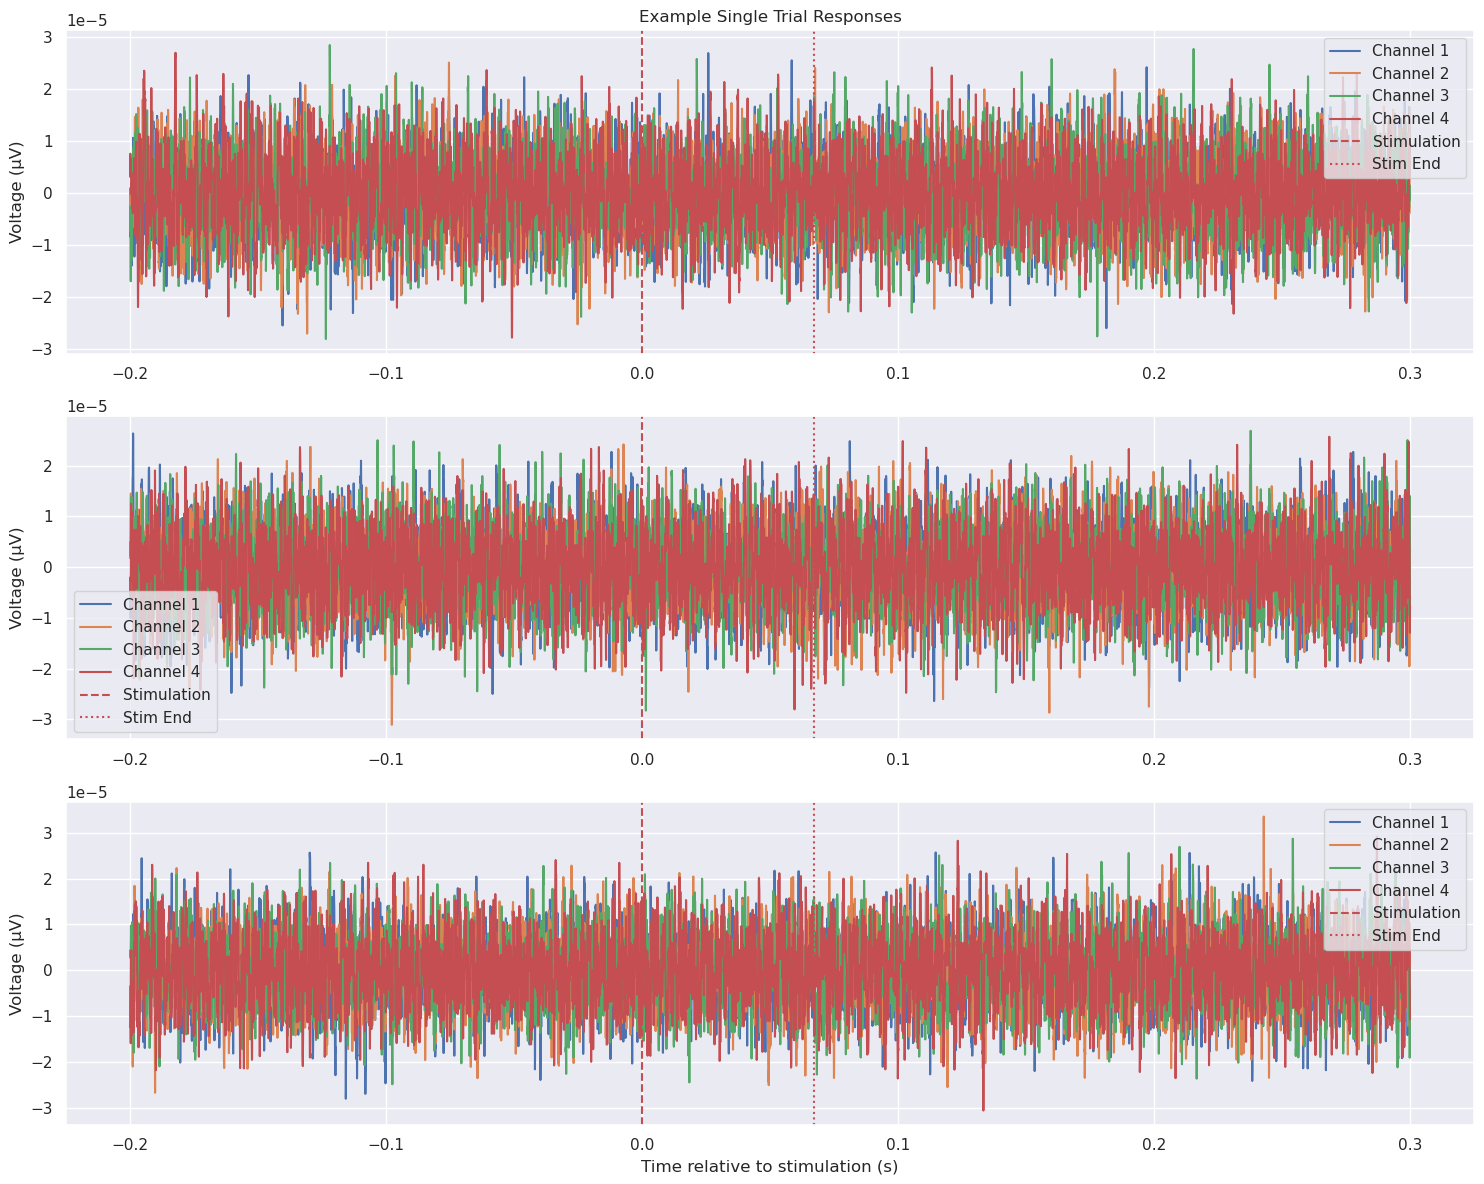

In [5]:
# Get electrical series info
electrical_series = nwb.acquisition['ElectricalSeries']
sampling_rate = electrical_series.rate

# Parameters for analysis
time_before = 0.2  # seconds before trial
time_after = 0.3   # seconds after trial
num_trials_to_plot = 3  # Number of example trials
num_channels = 4  # Number of channels to analyze

# Function to get data around a trial
def get_trial_data(trial_start):
    start_idx = max(0, int((trial_start - time_before) * sampling_rate))
    end_idx = min(electrical_series.data.shape[0], 
                  int((trial_start + time_after) * sampling_rate))
    data = electrical_series.data[start_idx:end_idx, :num_channels]
    time = np.arange(data.shape[0]) / sampling_rate - time_before
    return time, data

# Plot individual trial examples
plt.figure(figsize=(15, 12))
for trial_idx in range(num_trials_to_plot):
    trial_start = trial_starts[trial_idx]
    time, data = get_trial_data(trial_start)
    
    plt.subplot(num_trials_to_plot, 1, trial_idx + 1)
    for ch in range(num_channels):
        plt.plot(time, data[:, ch], label=f'Channel {ch+1}')
    plt.axvline(x=0, color='r', linestyle='--', label='Stimulation')
    plt.axvline(x=0.067, color='r', linestyle=':', label='Stim End')
    plt.grid(True)
    if trial_idx == 0:
        plt.title('Example Single Trial Responses')
    plt.ylabel('Voltage (μV)')
    if trial_idx == num_trials_to_plot - 1:
        plt.xlabel('Time relative to stimulation (s)')
    plt.legend()

plt.tight_layout()
plt.show()

### Trial-Averaged Response

To reduce noise and identify consistent patterns in the neural response, let's average across multiple trials:

Calculating trial-averaged response...


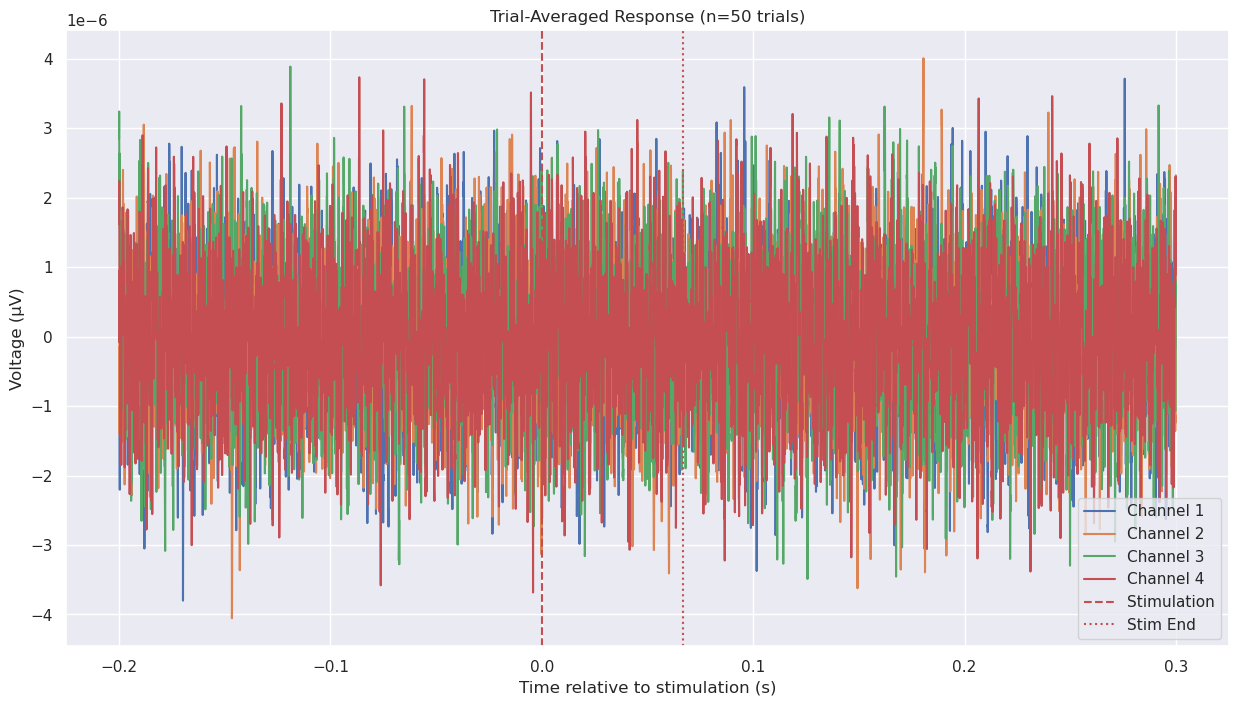

In [6]:
# Calculate trial-averaged response
print("Calculating trial-averaged response...")
num_trials_avg = 50  # Number of trials to average
samples_per_trial = int((time_before + time_after) * sampling_rate)
trial_avg = np.zeros((samples_per_trial, num_channels))
count = 0

for trial_idx in range(min(num_trials_avg, len(trial_starts))):
    time, data = get_trial_data(trial_starts[trial_idx])
    if data.shape[0] == samples_per_trial:  # Only use complete trials
        trial_avg += data
        count += 1

if count > 0:
    trial_avg /= count
    
    # Plot trial-averaged response
    plt.figure(figsize=(15, 8))
    time = np.linspace(-time_before, time_after, samples_per_trial)
    for ch in range(num_channels):
        plt.plot(time, trial_avg[:, ch], label=f'Channel {ch+1}')
    plt.axvline(x=0, color='r', linestyle='--', label='Stimulation')
    plt.axvline(x=0.067, color='r', linestyle=':', label='Stim End')
    plt.title(f'Trial-Averaged Response (n={count} trials)')
    plt.xlabel('Time relative to stimulation (s)')
    plt.ylabel('Voltage (μV)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Further Analysis Possibilities

This dataset offers several opportunities for additional analysis:

1. **Pressure-Response Relationship**: Compare neural responses across different ultrasound pressure levels
2. **Duty Cycle Effects**: Analyze how varying duty cycles affect neural activity
3. **PRF Impact**: Investigate the influence of different pulse repetition frequencies
4. **Spatial Response Patterns**: Study how responses vary across different electrode locations
5. **Response Latency**: Examine the timing of neural responses relative to stimulation onset

## Dataset Citation

When using this dataset, please cite:
```
Ramachandran, Sandhya; Gao, Huan; Yu, Kai; Yeh, Kelly; He, Bin (2025) Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound (Version draft) [Data set]. DANDI Archive. https://dandiarchive.org/dandiset/001363/draft
```